In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, words
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# used for removing punctuation
import string

# used for EDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Embedding, Concatenate, Reshape, RepeatVector, Input, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [2]:
!pip install wordsegment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.1 MB/s eta 0:00:00


In [45]:
# used to split concatenated words following hashtags
from wordsegment import load, segment
load()


In [46]:
nltk.download('stopwords')
nltk.download('words')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
from google.colab import files
files.upload()

# Github Repo

https://github.com/cfildish/CU_AI/tree/main/CSCA_5642_Deep_Learning/NLP_Disaster_Tweets

# Problem and Data Description

The goal of this problem is to predict whether tweets are real disasters or not based on their text, keyword about their content, and location (all text columns). There is also a unique id column in both datasets. There are a total of 10000 tweets, 7613 of which are in the train dataset with known labels. There are missing values for keyword and location:
* About 1/3 values are NA for location.
* Under 1% are NA for keyword.

# Download Dataset from Kaggle

In [48]:
!pip install -q kaggle

In [49]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [50]:
!chmod 600 ~/.kaggle/kaggle.json


In [51]:
!kaggle competitions download -c nlp-getting-started


nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [113]:
# Unzip the downloaded dataset
!unzip -o /content/nlp-getting-started.zip

# List the contents to find the CSV file (optional, but good for verification)
!ls

# # Load the survey_results_public.csv into a pandas DataFrame
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

# # Display the first few rows of the DataFrame
# df_survey.head()

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
'kaggle (1).json'   nlp-getting-started.zip   sample_submission.csv   train.csv
 kaggle.json	    sample_data		      test.csv


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Preparation

#### Confirm id is an identifier column and if it is, drop it

In [114]:
for col in train_df.columns:
  if train_df[col].nunique() == len(train_df):
    print(col)

id


In [115]:
train_df = train_df.drop(columns=["id"])


#### Print % NA Values in Train and Test Data

In [13]:
print(len(train_df))
train_df.isna().sum()/len(train_df)


7613


,0
keyword,0.008013
location,0.332720
text,0.000000
target,0.000000


In [14]:
print(len(test_df))
test_df.isna().sum()/len(test_df)


3263


,0
keyword,0.007968
location,0.338645
text,0.000000


#### Convert category and location columns to integers for train_df and test_df

In [116]:
# for now we treat NA locations and keywords as their own category
# replace NA values with unknown so they're not categorized as negative 1 when converted to int
train_df[["keyword", "location"]] = train_df[["keyword", "location"]].fillna("unknown")
test_df[["keyword", "location"]] = test_df[["keyword", "location"]].fillna("unknown")
train_df["keyword"] = train_df['keyword'].astype('category').cat.codes
train_df["location"] = train_df['location'].astype('category').cat.codes
test_df["keyword"] = test_df['keyword'].astype('category').cat.codes
test_df["location"] = test_df['location'].astype('category').cat.codes
train_df.head()

,keyword,location,text,target
0,206,3268,Our Deeds are the Reason of this #earthquake M...,1
1,206,3268,Forest fire near La Ronge Sask. Canada,1
2,206,3268,All residents asked to 'shelter in place' are ...,1
3,206,3268,"13,000 people receive #wildfires evacuation or...",1
4,206,3268,Just got sent this photo from Ruby #Alaska as ...,1


## Modifying Text Column

We do a few manual steps before tokenizing the text column, primarily with the goal of reducing dimensionality:
* If any words have a leading hashtag, if the word following is the concatenation of multiple words, split it
* Drop any words with leading https:// or http:// since these are likely unique
* Remove any words starting with @ because they are likely unique handles that provide little explanatory value
* Split any words with apostraphes into the individual words
* Remove stop words because we're trying to classify and not perform more complex text interpretation
* Stem words
* Finally remove words that do not have alphabetical characters

In [56]:
# Contraction map
c_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
    "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will",
    "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
    "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are",
    "you've": "you have"
}


In [57]:
def preprocess_text(df):
  for index, row in df.iterrows():
    for word in row["text"].split():
      if word[0] == "#":
        if word[1:] not in words.words():
          df.at[index, 'text'] = df.at[index, 'text'].replace(word, " ".join(segment(word)))
        else:
          df.at[index, 'text'] = df.at[index, 'text'].replace(word, word[1:])
      elif word.startswith("https://") or word.startswith("http://") or word.startswith("@"):
        df.at[index, 'text'] = df.at[index, 'text'].replace(word, "")
      elif word in c_dict:
        df.at[index, 'text'] = df.at[index, 'text'].replace(word, c_dict[word])

  for index, row in df.iterrows():
    for word in row["text"].split():
      if word in stopwords.words('english'):
        df.at[index, 'text'] = df.at[index, 'text'].replace(word, "")
      else:
        df.at[index, 'text'] = df.at[index, 'text'].replace(word, SnowballStemmer("english").stem(word.lower()))

  for index, row in df.iterrows():
    for word in row["text"].split():
      word_no_punctuation = word.rstrip(string.punctuation)
      df.at[index, 'text'] = df.at[index, 'text'].replace(word, word_no_punctuation)

  for index, row in df.iterrows():
    for word in row["text"].split():
      if not word.isalpha():
        df.at[index, 'text'] = df.at[index, 'text'].replace(word, "")

  return df



In [58]:
train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)


# EDA

## Distribution of Target Response in Train Data

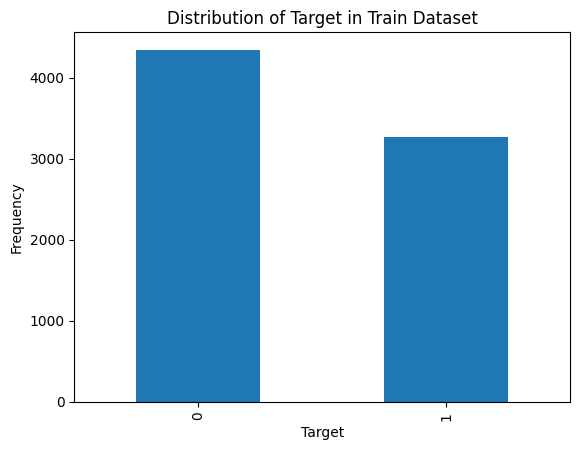

In [ ]:
plt.figure()
train_df["target"].value_counts().plot(kind="bar")
plt.title("Distribution of Target in Train Dataset")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()


Overall the target dataset is reasonably balanced between the two categories, so we don't need to worry about oversampling or undersampling.

## Plot Distribution of Location and Keyword Categories

### Location

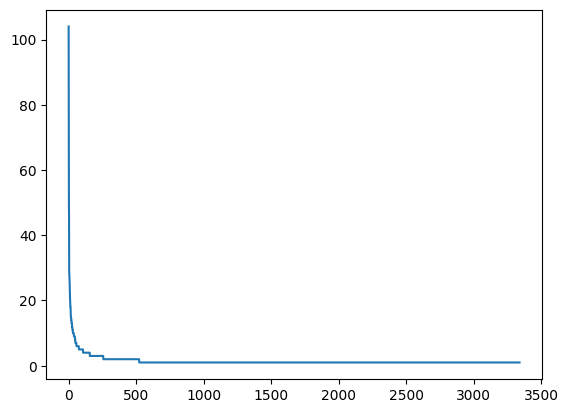

In [ ]:
plt.figure()
plt.plot(range(len(train_df["location"].value_counts())), train_df["location"].value_counts())
plt.show()


Because the location column is missing about a third of it's entries in test and train, and the rows that have values are mostly unique, we start by excluding the location column from the RNN model

### Keyword

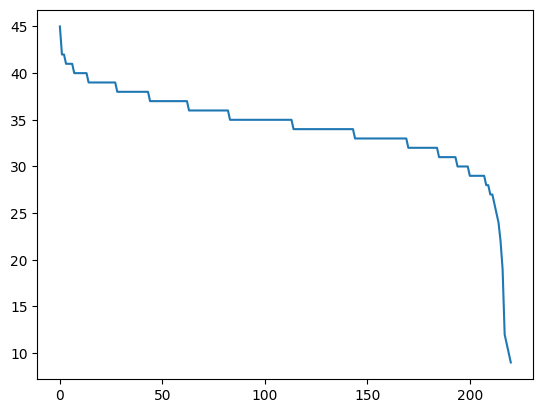

In [ ]:
plt.figure()
plt.plot(range(len(train_df["keyword"].value_counts())), train_df["keyword"].value_counts())
plt.show()


In contrast to the Location column, based on the visualization above the Keyword column has categories that are relatively evenly distributed so we may consider incorporating it with the text column in the RNN.

## Average Length of Words After Preprocessing

10


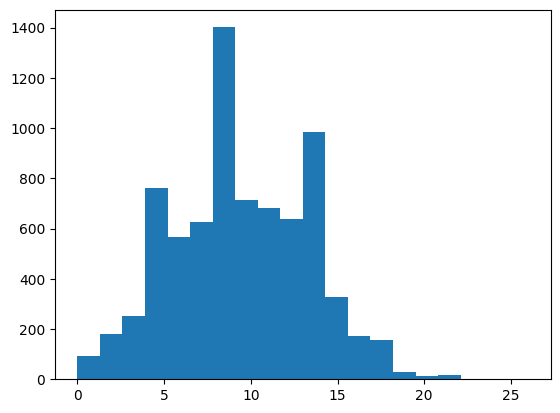

In [ ]:
#print the text lenght with the highest frequency
train_df["text_length"] = train_df["text"].apply(lambda x: len(x.split()))
print(train_df["text_length"].value_counts().idxmax())
plt.figure()
plt.hist(train_df["text_length"], bins=20)
plt.show()


10


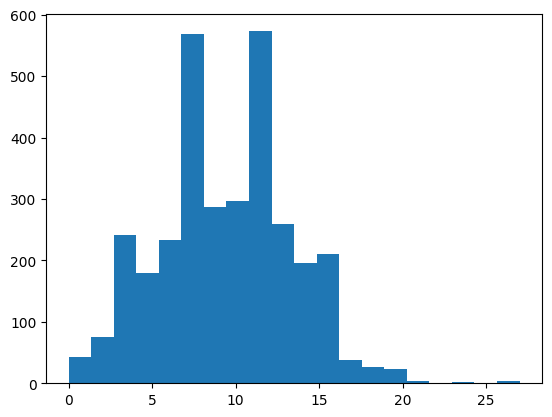

In [ ]:
#print the text lenght with the highest frequency
test_df["text_length"] = test_df["text"].apply(lambda x: len(x.split()))
print(test_df["text_length"].value_counts().idxmax())
plt.figure()
plt.hist(test_df["text_length"], bins=20)
plt.show()

Based on the visualizations above, we decide to set the max sequence length for the padding to 10 for the Keras tokenizer.

## Word Clouds for Train and Test Dataset



### Train

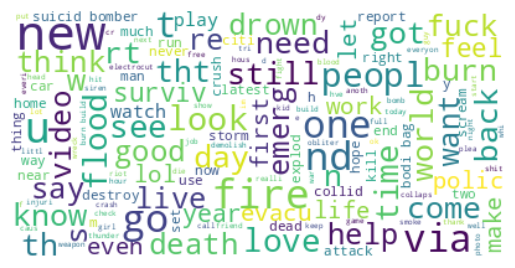

In [ ]:
## Processed Train
# Initialize `CountVectorizer` without removing stop words again.
vec = CountVectorizer(preprocessor=' '.join)
# join all text rows into one string
cleaned_chat_messages_string = ' '.join(train_df["text"])

# Construct a word cloud from corpus.
wordcloud = WordCloud(max_font_size = 40, background_color = "white")
wordcloud = wordcloud.generate(cleaned_chat_messages_string)

# Plot the cloud using matplotlib.
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Test

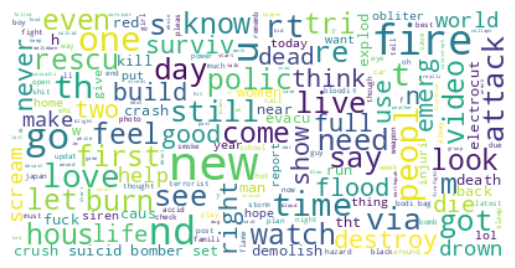

In [ ]:
## Processed Train
# Initialize `CountVectorizer` without removing stop words again.
vec = CountVectorizer(preprocessor=' '.join)
# join all text rows into one string
cleaned_chat_messages_string = ' '.join(test_df["text"])

# Construct a word cloud from corpus.
wordcloud = WordCloud(max_font_size = 40, background_color = "white")
wordcloud = wordcloud.generate(cleaned_chat_messages_string)

# Plot the cloud using matplotlib.
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


## Number of unique words and total number of words across the entire dataset

In [ ]:
from collections import Counter
import re

all_df = pd.concat([train_df, test_df])

# Find the number of words across all rows of train_df text that appear only once
all_words = []
for row_text in all_df["text"]:
    words = row_text.split()
    all_words.extend(words)

word_counts = Counter(all_words)

unique_words_count = 0
for word, count in word_counts.items():
    if count == 1:
        unique_words_count += 1

print(f"Total number of words apprearing in text: {len(word_counts)}")
print(f"Number of words appearing only once: {unique_words_count}")



Total number of words apprearing in text: 17309
Number of words appearing only once: 9731


# Model Architecture

In terms of data preparation, after the text columns modifications (explained above), I pass the updated text column to a keras tokenizer, ensuring that the train and test set both have the same tokenizer applied to them. For the tokenizer I decide to set max_padding to 10 based on the average word length explored in the EDA, which will set the length of all tweets to 10, shortening those that are longer and padding those that aren't. I also set num_words to 6500, which will set the max number of words used in the RNN to the 6500 most frequent words- this may be high but at omits at least unique words to start.

In terms of the architecture of the RNN, after the EDA above, I decide to omit the location column from modeling because there are a large number of unique and NA values, which likely wouldn't add a lot of explanatory value as is. However, I start by incorporating both the text and keyword columns by passing both through a embedding layer, then concatenate them before feeding the input into the RNN. For the RNN I decided to start with a single layer RNN using GRU.

To monitor the performance of the model over each epoch, I split the train dataset into a train and test set, and will add monitoring for both the train and test accuracies and loss to the RNN model so I can monitor the generalizability and attempt to avoid overfitting



## Keras Tokenizer

### Based on EDA above, setting max_padding to 10 and num_words to 6500

In [59]:
def tokenize_texts(texts, tokenizer, max_padding=10):
  # Tokenization and Vocabulary Creation

  # always fit on the train dataset, even when applying to test
  tokenizer.fit_on_texts(train_df["text"])
  word_index = tokenizer.word_index

  # Sequence Conversion
  sequences = tokenizer.texts_to_sequences(texts)

  # Padding
  max_sequence_length = max_padding
  padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

  return padded_sequences

In [20]:
tokenizer = Tokenizer(num_words=7578, oov_token="<unk>")
train_sequences = tokenize_texts(train_df["text"], tokenizer)
test_sequences = tokenize_texts(test_df["text"], tokenizer)


### Split dataset into test and train

This time there are two separate train datasets, one for category one for text

In [24]:
X_train_text, X_test_text, X_train_keyword, X_test_keyword, y_train, y_test = train_test_split(train_sequences, train_df["keyword"], train_df["target"], test_size=0.2)

## First Model

In [ ]:
keyword_vocab_size = train_df['keyword'].max() + 1

# Input layers
text_input = Input(shape=(10,), name='text_input')
keyword_input = Input(shape=(1,), name='keyword_input')

# Embedding layers
# Text
text_embedding_output = Embedding(input_dim=7578, output_dim=128, input_length=10)(text_input)

# Keyword
keyword_embedding_output = Embedding(input_dim=keyword_vocab_size, output_dim=32)(keyword_input)

# Reshape keyword embedding
keyword_embedding_reshaped = Reshape((32,))(keyword_embedding_output)

# Repeat categorical embeddings to match the time steps of the text embedding
keyword_repeated = RepeatVector(10)(keyword_embedding_reshaped)

# Concatenate all embeddings
combined_embeddings = Concatenate(axis=-1)([text_embedding_output, keyword_repeated])

# GRU layer
gru_out = GRU(128)(combined_embeddings)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(gru_out)

# Create
model = Model(inputs=[text_input, keyword_input], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keyword_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 32)     │      7,104 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 32)        │          0 │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 10, 128)   │    969,984 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 10, 32)    │          0 │ reshape_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10, 160)   │          0 │ embedding_10[0][… │
│ (Concatenate)       │                   │            │ repeat_vector_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 128)       │    111,360 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ gru_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,088,577 (4.15 MB)

 Trainable params: 1,088,577 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class TestSetEvaluation(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)
        print(f"\nEpoch {epoch+1}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

test_eval_callback = TestSetEvaluation([X_test_text, X_test_keyword], y_test)

In [ ]:
model.fit([X_train_text, X_train_keyword], y_train, epochs=30, callbacks=[test_eval_callback])


Epoch 1/30
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8738 - loss: 0.3116
Epoch 1: Test Loss: 0.5112, Test Accuracy: 0.7748
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8736 - loss: 0.3119
Epoch 2/30
181/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9170 - loss: 0.2099
Epoch 2: Test Loss: 0.6218, Test Accuracy: 0.7479
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9165 - loss: 0.2111
Epoch 3/30
180/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9405 - loss: 0.1580
Epoch 3: Test Loss: 0.8074, Test Accuracy: 0.7459
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9403 - loss: 0.1584
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9586 - loss: 0.1153
Epoch 4: Test Loss: 0.8376, Test Accuracy: 0.7393
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9586 - loss: 0.1153
Epoch 5/30
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9700 - loss: 0.0815
Epoch 5: Test Loss: 1.3008, Test Accuracy: 0.7433
191/191 ━━━━━━━━━━━━

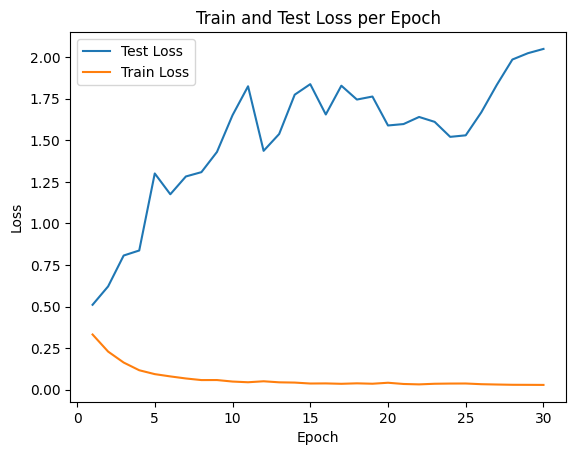

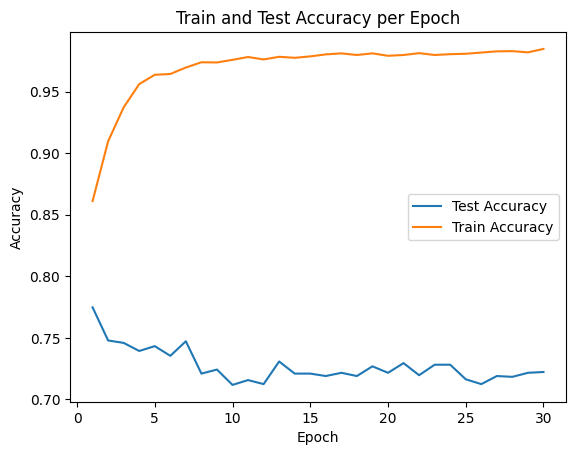

In [ ]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model.history.history['loss'], 'Train Accuracy': model.history.history['accuracy'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()
plt.show()

# Results and Analysis

## Model Update 1- Introduce a Dropout Layer

In [23]:
keyword_vocab_size = train_df['keyword'].max() + 1

# Input layers
text_input = Input(shape=(10,), name='text_input')
keyword_input = Input(shape=(1,), name='keyword_input')

# Embedding layers
# Text
text_embedding_output = Embedding(input_dim=7578, output_dim=128, input_length=10)(text_input)

# Keyword
keyword_embedding_output = Embedding(input_dim=keyword_vocab_size, output_dim=32)(keyword_input)

# Reshape keyword embedding
keyword_embedding_reshaped = Reshape((32,))(keyword_embedding_output)

# Repeat categorical embeddings to match the time steps of the text embedding
keyword_repeated = RepeatVector(10)(keyword_embedding_reshaped)

# Concatenate all embeddings
combined_embeddings = Concatenate(axis=-1)([text_embedding_output, keyword_repeated])

# GRU layer
gru_out = GRU(128)(combined_embeddings)

# dropout layer
dropout_layer = Dropout(0.5)(gru_out)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create
model = Model(inputs=[text_input, keyword_input], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keyword_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 32)     │      7,104 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 128)   │    969,984 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 32)    │          0 │ reshape_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 160)   │          0 │ embedding_2[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128)       │    111,360 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,088,577 (4.15 MB)

 Trainable params: 1,088,577 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
test_eval_callback = TestSetEvaluation([X_test_text, X_test_keyword], y_test)
model.fit([X_train_text, X_train_keyword], y_train, epochs=30, callbacks=[test_eval_callback])

Epoch 1/30
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6594 - loss: 0.6001
Epoch 1: Test Loss: 0.4793, Test Accuracy: 0.7820
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6613 - loss: 0.5983
Epoch 2/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.3186
Epoch 2: Test Loss: 0.5362, Test Accuracy: 0.7577
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8781 - loss: 0.3189
Epoch 3/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9225 - loss: 0.2144
Epoch 3: Test Loss: 0.6522, Test Accuracy: 0.7485
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9223 - loss: 0.2148
Epoch 4/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9407 - loss: 0.1599
Epoch 4: Test Loss: 0.6372, Test Accuracy: 0.7111
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9406 - loss: 0.1602
Epoch 5/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9592 - loss: 0.1205
Epoch 5: Test Loss: 0.8033, Test Accuracy: 0.7485
191/191 ━━━━━━━━━━━━

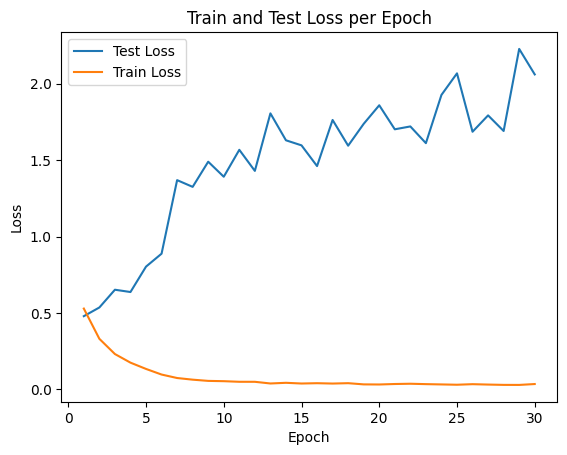

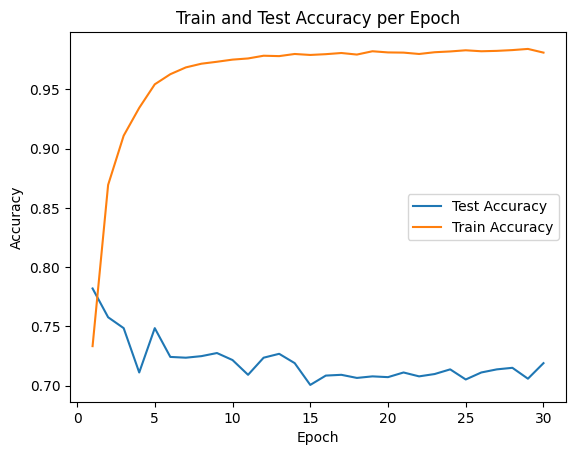

In [27]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model.history.history['loss'], 'Train Accuracy': model.history.history['accuracy'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()
plt.show()


Introducing the dropout layer with a rate of 50% after the RNN layer did not help very much with overfitting. There's still a huge gap between the train and test accuracies and losses suggeting there's more we can do to improve the generalizability.

## Model Update 2- Introduce L2 Regularization in GRU

In [36]:
keyword_vocab_size = train_df['keyword'].max() + 1

# Input layers
text_input = Input(shape=(10,), name='text_input')
keyword_input = Input(shape=(1,), name='keyword_input')

# Embedding layers
# Text
text_embedding_output = Embedding(input_dim=7578, output_dim=128, input_length=10)(text_input)

# Keyword
keyword_embedding_output = Embedding(input_dim=keyword_vocab_size, output_dim=32)(keyword_input)

# Reshape keyword embedding
keyword_embedding_reshaped = Reshape((32,))(keyword_embedding_output)

# Repeat categorical embeddings to match the time steps of the text embedding
keyword_repeated = RepeatVector(10)(keyword_embedding_reshaped)

# Concatenate all embeddings
combined_embeddings = Concatenate(axis=-1)([text_embedding_output, keyword_repeated])

# GRU layer
gru_out = GRU(128, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(combined_embeddings)

# dropout layer
dropout_layer = Dropout(0.5)(gru_out)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create
model = Model(inputs=[text_input, keyword_input], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keyword_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 32)     │      7,104 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 32)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 10, 128)   │    969,984 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 10, 32)    │          0 │ reshape_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 10, 160)   │          0 │ embedding_6[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 128)       │    111,360 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,088,577 (4.15 MB)

 Trainable params: 1,088,577 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
test_eval_callback = TestSetEvaluation([X_test_text, X_test_keyword], y_test)
model.fit([X_train_text, X_train_keyword], y_train, epochs=30, callbacks=[test_eval_callback])

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5929 - loss: 2.0544
Epoch 1: Test Loss: 0.5466, Test Accuracy: 0.7748
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5933 - loss: 2.0498
Epoch 2/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8478 - loss: 0.4288
Epoch 2: Test Loss: 0.5682, Test Accuracy: 0.7774
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8478 - loss: 0.4287
Epoch 3/30
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8976 - loss: 0.3158
Epoch 3: Test Loss: 0.6353, Test Accuracy: 0.7623
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8974 - loss: 0.3160
Epoch 4/30
181/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9309 - loss: 0.2403
Epoch 4: Test Loss: 0.6830, Test Accuracy: 0.7610
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9304 - loss: 0.2414
Epoch 5/30
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9348 - loss: 0.2167
Epoch 5: Test Loss: 0.7725, Test Accuracy: 0.7518
191/191 ━━━━━━━━━━━━

0.5465681552886963


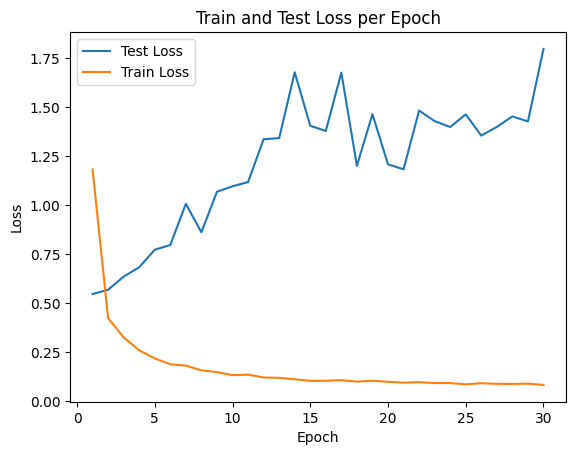

0.777413010597229


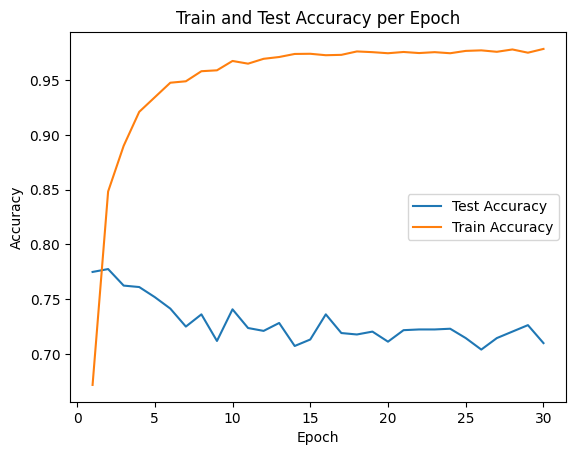

In [40]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model.history.history['loss'], 'Train Accuracy': model.history.history['accuracy'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

print(plot_df["Test Loss"].min())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.show()

print(plot_df["Test Accuracy"].max())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()
plt.show()

Introducing L2 regularization to the GRU RNN layer seemed to help a bit with overfitting, but there's still a huge gap. Next we'll look to adjust the input data.

## Model Update 3- Adjust the number of max_words used in the tokenizer

Because we've introduced multiple techniques to reduce overfitting in the RNN architecture with little success, I modify the tokenizer to optimize for the max number of words included in the text column. We'll also increase the dropout rate after the RNN layer.

In [ ]:
max_words = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
res_dict = {"Max_Words": [], "Loss": [], "Accuracy": []}

for max_word in max_words:
  res_dict["Max_Words"].append(max_word)
  tokenizer = Tokenizer(num_words=max_word, oov_token="<unk>")
  train_sequences = tokenize_texts(train_df["text"], tokenizer)
  test_sequences = tokenize_texts(test_df["text"], tokenizer)

  X_train_text, X_test_text, X_train_keyword, X_test_keyword, y_train, y_test = train_test_split(train_sequences, train_df["keyword"], train_df["target"], test_size=0.2)

  keyword_vocab_size = train_df['keyword'].max() + 1

  # Input layers
  text_input = Input(shape=(10,), name='text_input')
  keyword_input = Input(shape=(1,), name='keyword_input')

  # Embedding layers
  # Text
  text_embedding_output = Embedding(input_dim=max_word, output_dim=128)(text_input)

  # Keyword
  keyword_embedding_output = Embedding(input_dim=keyword_vocab_size, output_dim=32)(keyword_input)

  # Reshape keyword embedding
  keyword_embedding_reshaped = Reshape((32,))(keyword_embedding_output)

  # Repeat categorical embeddings to match the time steps of the text embedding
  keyword_repeated = RepeatVector(10)(keyword_embedding_reshaped)

  # Concatenate all embeddings
  combined_embeddings = Concatenate(axis=-1)([text_embedding_output, keyword_repeated])

  # GRU layer
  gru_out = GRU(128, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(combined_embeddings)

  # dropout layer
  dropout_layer = Dropout(0.7)(gru_out)

  # Output layer for binary classification
  output_layer = Dense(1, activation='sigmoid')(dropout_layer)

  # Create
  model = Model(inputs=[text_input, keyword_input], outputs=output_layer)

  # Compile
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  test_eval_callback = TestSetEvaluation([X_test_text, X_test_keyword], y_test)
  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit([X_train_text, X_train_keyword], y_train, epochs=30, callbacks=[test_eval_callback, early_stopping_callback], validation_data=([X_test_text, X_test_keyword], y_test))

  # take the 6th loss because the early stopping patience is set to 5
  res_dict["Loss"].append(test_eval_callback.test_loss[-6])
  res_dict["Accuracy"].append(test_eval_callback.test_accuracy[-6])

res_df = pd.DataFrame(res_dict)


In [76]:
res_df = res_df.sort_values(by=["Loss"], ascending=True)
res_df

,Max_Words,Loss,Accuracy
6,1750,0.487881,0.796454
2,750,0.504567,0.773473
1,500,0.510810,0.782666
3,1000,0.511037,0.782009
7,2000,0.514304,0.777413
5,1500,0.517109,0.797111
4,1250,0.517197,0.783322
0,250,0.538879,0.766907


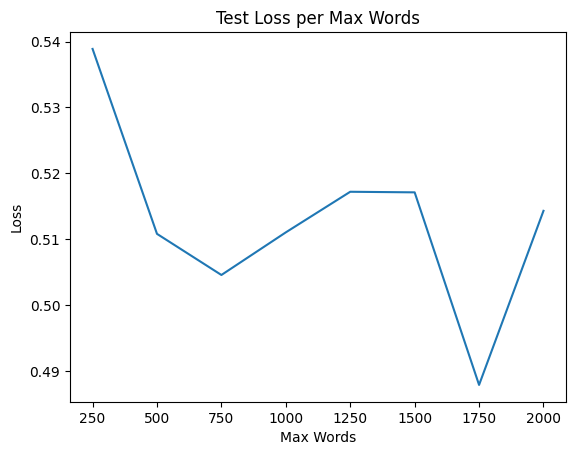

In [94]:
plot_df = res_df.sort_values(by=["Max_Words"], ascending=True)

plt.figure()
plt.plot(plot_df["Max_Words"], plot_df["Loss"])
plt.xlabel("Max Words")
plt.ylabel("Loss")
plt.title("Test Loss per Max Words")
plt.show()


Looks like the optimal number of max words appears to be around 1750 for the RNN architecture provided. We use this to build the best model (in terms of test loss and accuracy) from the variations I've tried.

In [108]:
tokenizer = Tokenizer(num_words=1750, oov_token="<unk>")
train_sequences = tokenize_texts(train_df["text"], tokenizer)
test_sequences = tokenize_texts(test_df["text"], tokenizer)

In [109]:
X_train_text, X_test_text, X_train_keyword, X_test_keyword, y_train, y_test = train_test_split(train_sequences, train_df["keyword"], train_df["target"], test_size=0.2)


In [110]:
keyword_vocab_size = train_df['keyword'].max() + 1

# Input layers
text_input = Input(shape=(10,), name='text_input')
keyword_input = Input(shape=(1,), name='keyword_input')

# Embedding layers
# Text
text_embedding_output = Embedding(input_dim=1750, output_dim=128)(text_input)

# Keyword
keyword_embedding_output = Embedding(input_dim=keyword_vocab_size, output_dim=32)(keyword_input)

# Reshape keyword embedding
keyword_embedding_reshaped = Reshape((32,))(keyword_embedding_output)

# Repeat categorical embeddings to match the time steps of the text embedding
keyword_repeated = RepeatVector(10)(keyword_embedding_reshaped)

# Concatenate all embeddings
combined_embeddings = Concatenate(axis=-1)([text_embedding_output, keyword_repeated])

# GRU layer
gru_out = GRU(128, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(combined_embeddings)

# dropout layer
dropout_layer = Dropout(0.7)(gru_out)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create
model = Model(inputs=[text_input, keyword_input], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keyword_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_58        │ (None, 1, 32)     │      7,104 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_28          │ (None, 32)        │          0 │ embedding_58[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_57        │ (None, 10, 128)   │    224,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 10, 32)    │          0 │ reshape_28[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 10, 160)   │          0 │ embedding_57[0][… │
│ (Concatenate)       │                   │            │ repeat_vector_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ (None, 128)       │    111,360 │ concatenate_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ gru_29[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1)         │        129 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,593 (1.31 MB)

 Trainable params: 342,593 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
test_eval_callback = TestSetEvaluation([X_test_text, X_test_keyword], y_test)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit([X_train_text, X_train_keyword], y_train, epochs=30, callbacks=[test_eval_callback, early_stopping_callback], validation_data=([X_test_text, X_test_keyword], y_test))


Epoch 1/30
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5872 - loss: 2.0956
Epoch 1: Test Loss: 0.5518, Test Accuracy: 0.7649
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5891 - loss: 2.0682 - val_accuracy: 0.7649 - val_loss: 0.5518
Epoch 2/30
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8091 - loss: 0.4881
Epoch 2: Test Loss: 0.5091, Test Accuracy: 0.7859
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8090 - loss: 0.4882 - val_accuracy: 0.7859 - val_loss: 0.5091
Epoch 3/30
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8341 - loss: 0.4361
Epoch 3: Test Loss: 0.5099, Test Accuracy: 0.7748
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8342 - loss: 0.4360 - val_accuracy: 0.7748 - val_loss: 0.5099
Epoch 4/30
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 0.3957
Epoch 4: Test Loss: 0.5589, Test Accuracy: 0.7617
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8430 - loss: 0.3958 - val_accuracy: 0.7617 - val_l

In [99]:
print(test_eval_callback.test_loss[-6])

0.4969569742679596


0.5091077089309692


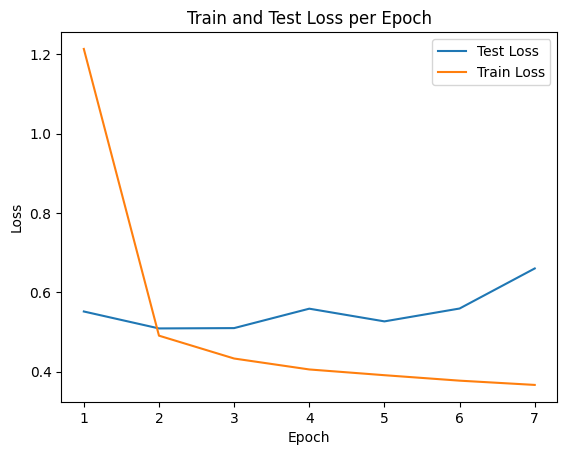

0.7859488129615784


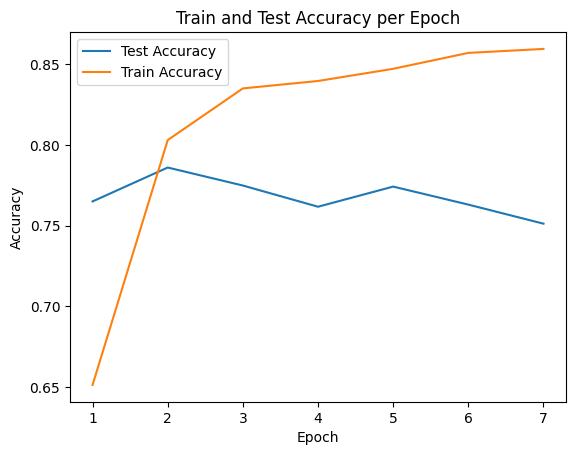

In [112]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model.history.history['loss'], 'Train Accuracy': model.history.history['accuracy'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

print(plot_df["Test Loss"].min())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.show()

print(plot_df["Test Accuracy"].max())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()
plt.show()

Much better! It appears the size of the words used in the original dataset was the biggest issue with overfitting in the earlier models, not the architecture. There are still some issues with overfitting that could be explored further, but this is an improvement.

# Kaggle Result

## Create submission for Kaggle

In [119]:
test_pred_proba = model.predict([test_sequences,test_df["keyword"]])
test_pred_binary = (test_pred_proba >= 0.5).astype(int)
test_pred_binary = test_pred_binary.reshape(1, -1)[0]
print(len(test_pred_binary))
test_pred_binary[0:10]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3263


array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0])

In [121]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [122]:
res_df = pd.DataFrame({"id": test_df["id"], "target": test_pred_binary})
res_df.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/submission.csv', index=False)


## Kaggle Score- 0.78148 (rank 807)

# Conclusion

Overall the results improved dramatically from the first model I tried. One of the biggest takeaways I had with this project is to start simple in terms of input data with neural networks- more often than not when using them I've had to address overfitting, so it would have made more sense to start with a very small number of max words in the Keras tokenizer and expand, as opposed to starting with as robust a dataset as possible. This caused the RNN to overfit even when applying methods to reduce it.

If I had more time, here are some other things I'd improve on in the future:
* Use machine learning to predict the missing categories into one of the existing categories
* If I had more time I'd like to figure out how to use the Location column, either by broadly categorizing the location by region (e.g. states/countries) prior to fitting, or seeing if the RNN could handle interpret Location column well with an embedding layer.
* Try different RNN models aside from GRU

# References

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

https://keras.io/keras_hub/api/tokenizers/tokenizer/

https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

https://stackoverflow.com/questions/72013197/evaluate-model-on-testing-set-after-each-epoch-of-training
